In [1]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')
from datetime import datetime
from io import StringIO
import re
import numpy as np
import os
from tqdm import tqdm
import json as js
import codecs
import subprocess

sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]


In [2]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)
    #return lst2
    #print(lst2,cliffsDelta(lst1,lst2)) # should return False

# LOADING THE USED DATAFRAMES

In [3]:
technical_lag=pd.read_csv('../../npm_docker/csv/docker_packages_timelag.csv', 
                            sep=';', dtype=object, index_col=None,  error_bad_lines=False)
technical_lag['base_os']=technical_lag['base_os'].apply(lambda x: x.title())
technical_lag['slug']=technical_lag.tag.apply(lambda x: x.split(':')[0])
print(len(technical_lag))
technical_lag.head(2)

290031


,package,version,created,tag,base_os,latest,date,release_type,date_latest,version_lag,extraction_date,version_lag_today,slug
0,1to2,1.0.0,2016-08-01,ghost:0.8,Debian,1.0.0,2016-04-19,initial,2016-04-19,"0,0,0",2018-03-13,"0,0,0",ghost
1,1to2,1.0.0,2016-09-28,ghost:0.11.0,Debian,1.0.0,2016-04-19,initial,2016-04-19,"0,0,0",2018-03-13,"0,0,0",ghost


In [4]:
vulnerabilities=pd.read_csv('../../npm_docker/csv/affected_packages.csv', 
                            sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(vulnerabilities))
vulnerabilities.head(2)

40792


,package,version,versions,tag,base_os,created,id,name,published,severity,disclosed,affected
0,atob,2.0.3,<2.1.0,ghost:1.18-alpine,alpine,2017-12-09,npm:atob:20180429,Uninitialized Memory Exposure,"30 Apr, 2018",medium,"29 Apr, 2018",True
1,atob,2.0.3,<2.1.0,ghost:1.18.2,debian,2017-12-05,npm:atob:20180429,Uninitialized Memory Exposure,"30 Apr, 2018",medium,"29 Apr, 2018",True


# ANALYSIS

# RQ0: How many npm packages are installed in Docker images?

In [5]:
df_tmp=technical_lag[['tag','slug','base_os']].drop_duplicates()
df_tmp.groupby(['base_os','slug']).count()

tag
base_os slug              
Alpine  ghost           35
        node            84
Debian  ghost           40
        mongo-express   17
        node           785

In [6]:
technical_lag['tag'].drop_duplicates().size

961

In [7]:
df_tmp=technical_lag[['tag','base_os','created']].drop_duplicates()
#df_tmp['created']=df_tmp.created.apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1]+'-01')

df_tmp['created']=df_tmp['created'].apply(lambda x: 
                                      x[0:4] )
    
df_tmp.groupby(['base_os']).count()#/9.61#reset_index()/961


,tag,created
base_os,,
Alpine,119,119
Debian,842,842


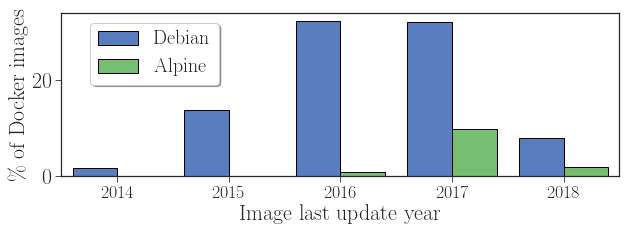

In [8]:
df_tmp=technical_lag[['tag','base_os','created']].drop_duplicates()
#df_tmp['created']=df_tmp.created.apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1]+'-01')

df_tmp['created']=df_tmp['created'].apply(lambda x: 
                                      x[0:4] )
    
df_tmp=df_tmp.groupby(['created','base_os']).count()/9.61
df_tmp.reset_index(inplace=True)
ax = sns.barplot(
    y="tag", x='created', hue='base_os', data=df_tmp, 
    palette="muted", linewidth=1)

ax.legend('')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_xlabel("Image last update year")
ax.set_ylabel("\% of Docker images")
ax.figure.set_size_inches(10,3)

ax.legend(loc='upper right', bbox_to_anchor=(0.3, 1), ncol=1, fontsize=20, fancybox=True, shadow=True)
#ax.figure.savefig('../../../papers/cloudtech18/figures/last_update.pdf', bbox_inches='tight', facecolor='white')


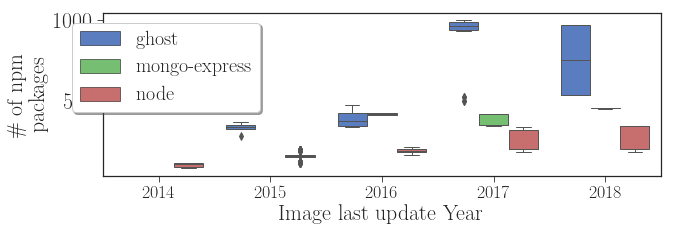

In [265]:
df_tmp=technical_lag[['tag','slug','created','package']].drop_duplicates()
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0] )
df_tmp=df_tmp.groupby(['tag','created','slug']).count().reset_index()
df_tmp1=df_tmp.groupby(['tag','created','slug']).count().reset_index()
ax = sns.boxplot(x="created", y="package", data=df_tmp, hue='slug', palette="muted", linewidth=1)
ax.figure.set_size_inches(10,3)
ax.set_xlabel('Image last update Year')
ax.set_ylabel('\# of npm \n packages')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(0.3, 1), ncol=1, fontsize=20, fancybox=True, shadow=True)

In [9]:
df_tmp=technical_lag[['tag','slug','created','package']].drop_duplicates()
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0] )
df_tmp=df_tmp.groupby(['tag','created','slug']).count().reset_index()
df_tmp.query('slug=="node"').package.median()

200.0

In [10]:
df_tmp.query('slug=="ghost"').package.median()

959.0

In [10]:
df_tmp.query('slug=="mongo-express"').package.median()

419.0

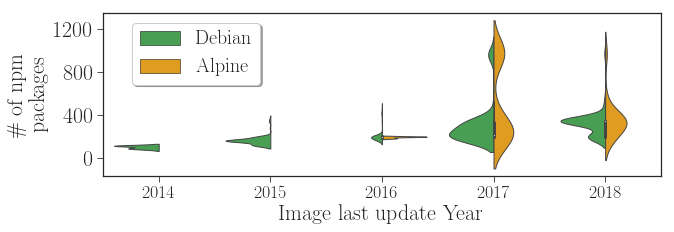

In [11]:
df_tmp=technical_lag[['tag','base_os','created','package']].drop_duplicates()
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0] )
df_tmp=df_tmp.groupby(['tag','created','base_os']).count().reset_index()

ax = sns.violinplot(x="created", y="package", data=df_tmp, hue='base_os', palette=flatui, linewidth=1, split=True)
ax.figure.set_size_inches(10,3)
ax.set_xlabel('Image last update Year')
ax.set_ylabel('\# of npm \n packages')
for patch in ax.patches:
    patch.set_edgecolor('black')
#ax.set_ylim(-10,800)
plt.yticks(np.arange(0, 1201, 400.0))

ax.legend(loc='upper right', bbox_to_anchor=(0.3, 1), ncol=1, fontsize=20, fancybox=True, shadow=True)
ax.figure.savefig('../../../seneca_research/docker_npm/figures/npm_number_os.pdf', bbox_inches='tight', facecolor='white')


In [12]:
df_tmp=technical_lag[['tag','base_os','created','package']].drop_duplicates()
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0] )
df_tmp=df_tmp.groupby(['tag','created','base_os']).count().reset_index()
df_tmp.query('base_os=="Alpine"').package.median()

322.0

In [13]:
df_tmp.query('base_os=="Debian"').package.median()

200.5

In [14]:
technical_lag[['slug','tag']].drop_duplicates().groupby('slug').count()

,tag
slug,
ghost,75
mongo-express,17
node,869


In [12]:
technical_lag[['slug','base_os','tag']].drop_duplicates().groupby(['slug','base_os']).count()

tag
slug          base_os     
ghost         Alpine    35
              Debian    40
mongo-express Debian    17
node          Alpine    84
              Debian   785

In [13]:
for x in range(2016,2019):
    cliffsDelta(df_tmp.query('base_os=="Alpine"').query('created=="'+str(x)+'"').package, 
            df_tmp.query('base_os=="Debian"').query('created=="'+str(x)+'"').package)

d=0.06129032258064516
d=0.24153771760154738
d=0.04489164086687306


In [15]:
for x in range(2016,2019):
    print(x,scipy.stats.mannwhitneyu(df_tmp.query('base_os=="Alpine"').query('created=="'+str(x)+'"').package, 
            df_tmp.query('base_os=="Debian"').query('created=="'+str(x)+'"').package))

2016 MannwhitneyuResult(statistic=1164.0, pvalue=0.38265676575312257)
2017 MannwhitneyuResult(statistic=10979.5, pvalue=0.00018557311687938727)
2018 MannwhitneyuResult(statistic=617.0, pvalue=0.36881636060790757)


# RQ1: What is the technical lag induced by outdated packages in containers?

In [11]:
technical_lag.head(2)

,package,version,created,tag,base_os,latest,date,release_type,date_latest,version_lag,extraction_date,version_lag_today,slug
0,1to2,1.0.0,2016-08-01,ghost:0.8,Debian,1.0.0,2016-04-19,initial,2016-04-19,"0,0,0",2018-03-13,"0,0,0",ghost
1,1to2,1.0.0,2016-09-28,ghost:0.11.0,Debian,1.0.0,2016-04-19,initial,2016-04-19,"0,0,0",2018-03-13,"0,0,0",ghost


At the time of the last update, how was the technical lag?

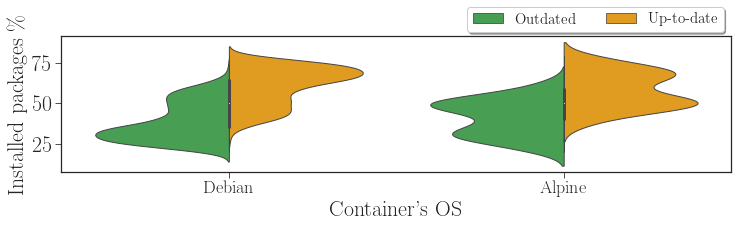

In [13]:
# at the date of the last update
df_tmp=technical_lag.drop('extraction_date', axis=1)
df_tmp['outdate']=df_tmp.apply(lambda d: 'Up-to-date' if d['latest']==d['version']
                              else 'Outdated', axis=1)

df_tmp1=df_tmp[['package','version','tag','base_os','slug','outdate']].drop_duplicates()
dff1=df_tmp1.groupby(['tag','base_os','outdate']).count().loc[:,['package']].reset_index()
dff2=df_tmp1.groupby(['tag','base_os']).count().reset_index().loc[:,['tag','version']]

dff=(dff1.
     merge(
         dff2,
         left_on='tag',
         right_on='tag',
         how='left').
     assign(installed=lambda d: (d['package']*100/d['version']).apply(int)).
     drop(['version','package'], axis=1)
    )


ax = sns.violinplot(split=True, x="base_os", y="installed", hue="outdate",
                 data=dff, palette=flatui, linewidth=1)
ax.figure.set_size_inches(12,2.5)
ax.set_ylabel('Installed packages \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_xlabel("Container's OS")
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.27), ncol=3, fontsize=15, fancybox=True, shadow=True)
#ax.figure.savefig('../../../seneca_research/docker_npm/figures/update.pdf', bbox_inches='tight', facecolor='white')


In [14]:
sample1=dff.query('outdate=="Up-to-date" and base_os=="Alpine"').installed
sample2=dff.query('outdate=="Up-to-date" and base_os=="Debian"').installed
print(scipy.stats.mannwhitneyu(sample2,sample1), cliffsDelta(sample2,sample1))
print('\nmedian','\t\tAlpine',sample1.median(), 'Debian',sample2.median())

d=0.1392143555759596
MannwhitneyuResult(statistic=43124.5, pvalue=0.0069018515544265607) False

median 		Alpine 57.0 Debian 64.0


In [15]:
df_tmp=technical_lag.drop('extraction_date', axis=1)
df_tmp['outdate']=df_tmp.apply(lambda d: 'Up-to-date' if d['version_lag_today']=='0,0,0'
                              else 'Out-of-date', axis=1)

df_tmp1=df_tmp[['package','version','tag','base_os','slug','outdate']].drop_duplicates()
dff1=df_tmp1.groupby(['tag','base_os','outdate']).count().loc[:,['package']].reset_index()
dff2=df_tmp1.groupby(['tag','base_os']).count().reset_index().loc[:,['tag','version']]

dff=(dff1.
     merge(
         dff2,
         left_on='tag',
         right_on='tag',
         how='left').
     assign(installed=lambda d: (d['package']*100/d['version']).apply(int)).
     drop(['version','package'], axis=1)
    )

In [16]:
sample1=dff.query('outdate=="Up-to-date" and base_os=="Alpine"').installed
sample2=dff.query('outdate=="Up-to-date" and base_os=="Debian"').installed
print(scipy.stats.mannwhitneyu(sample2,sample1), cliffsDelta(sample2,sample1))
print('\nmedian','\t\tAlpine',sample1.median(), 'Debian',sample2.median())

d=-0.4103275514481327
MannwhitneyuResult(statistic=29542.0, pvalue=1.7855699102337304e-13) True

median 		Alpine 41.0 Debian 34.0


In [17]:
df_tmp=technical_lag.query('latest!=version')

#### For those who are outdated! what is the technical lag
df_tmp['date_latest']=df_tmp['date_latest'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

df_tmp['time_lag']=df_tmp.apply(lambda d: (d['date_latest'] - d['date']).days/30, axis=1)

df_tmp.head()
#ax.figure.savefig('../../seneca_research/docker_debian/figures/version_lag.pdf', bbox_inches='tight', facecolor='white')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,package,version,created,tag,base_os,latest,date,release_type,date_latest,version_lag,extraction_date,version_lag_today,slug,time_lag
109,@segment/loosely-validate-event,1.1.2,2018-03-21,ghost:1,Debian,2.0.0,2017-02-10,patch,2018-01-24,"1,0,0",2018-03-13,"1,0,0",ghost,11.600000
110,@segment/loosely-validate-event,1.1.2,2018-03-21,ghost:1-alpine,Alpine,2.0.0,2017-02-10,patch,2018-01-24,"1,0,0",2018-03-13,"1,0,0",ghost,11.600000
115,CSSselect,0.4.1,2015-03-10,ghost:0.5.9,Debian,0.7.0,2014-02-14,patch,2014-03-05,"0,2,0",2018-03-13,"0,2,0",ghost,0.633333
190,JSONStream,1.2.1,2017-01-05,node:7.4-alpine,Alpine,1.3.0,2016-09-24,patch,2016-12-15,"0,1,0",2018-03-13,"0,1,2",node,2.733333
191,JSONStream,1.2.1,2017-01-17,node:7.4-slim,Debian,1.3.0,2016-09-24,patch,2016-12-15,"0,1,0",2018-03-13,"0,1,2",node,2.733333


In [18]:
data=df_tmp[['package','created','base_os','time_lag']]
data['created']=data['created'].apply(lambda x: x.split('-')[0])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


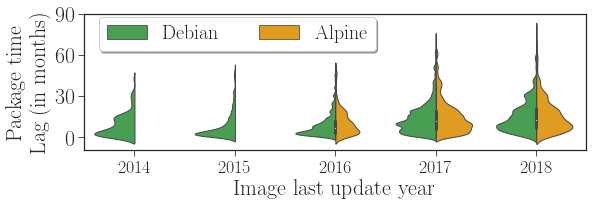

In [26]:

ax = sns.violinplot(split=True, x="created", y="time_lag", data=data, hue='base_os', palette=flatui, linewidth=1)

ax.figure.set_size_inches(9,2.5)
ax.set_xlabel("Image last update year")
ax.set_ylabel('Package time \n Lag (in months)')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(0.6, 1.05), ncol=2, fontsize=20, fancybox=True, shadow=True)
plt.yticks(np.arange(0, 100, 30))

#ax.set_ylim(0,50)
ax.figure.savefig('../../../seneca_research/docker_npm/figures/time_lag.pdf', bbox_inches='tight', facecolor='white')


In [27]:
sample1=data.query('base_os=="Alpine"').query('created>"2013"').time_lag
sample2=data.query('base_os=="Debian"').query('created>"2013"').time_lag
print(scipy.stats.mannwhitneyu(sample2,sample1), cliffsDelta(sample2,sample1))
print('\nmedian','\t\tAlpine',sample1.median(), 'Debian',sample2.median())

d=-0.16182121040390526
MannwhitneyuResult(statistic=1088874220.0, pvalue=0.0) True

median 		Alpine 12.133333333333333 Debian 9.2


In [28]:
data.time_lag.median()

9.733333333333333

In [29]:
df_tmp=technical_lag.query('version_lag!="0,0,0"')

#### For those who are outdated! what is the technical lag
df_tmp['major']=df_tmp['version_lag'].apply(lambda x: int(x.split(',')[0]))
df_tmp['minor']=df_tmp['version_lag'].apply(lambda x: int(x.split(',')[1]))
df_tmp['patch']=df_tmp['version_lag'].apply(lambda x: int(x.split(',')[2]))
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0])

df_tmp.head(2)
#ax.figure.savefig('../../../seneca_research/docker_npm/figures/version_lag.pdf', bbox_inches='tight', facecolor='white')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,package,version,created,tag,base_os,latest,date,release_type,date_latest,version_lag,extraction_date,version_lag_today,slug,major,minor,patch
109,@segment/loosely-validate-event,1.1.2,2018,ghost:1,Debian,2.0.0,2017-02-10,patch,2018-01-24,"1,0,0",2018-03-13,"1,0,0",ghost,1,0,0
110,@segment/loosely-validate-event,1.1.2,2018,ghost:1-alpine,Alpine,2.0.0,2017-02-10,patch,2018-01-24,"1,0,0",2018-03-13,"1,0,0",ghost,1,0,0


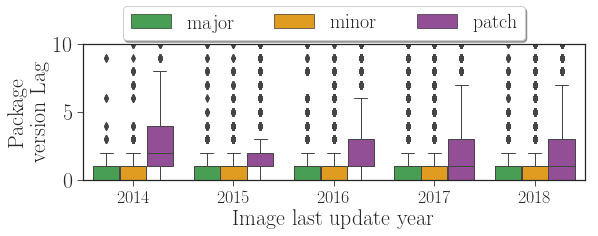

In [34]:
# at the time of the last update
df_tmp2=df_tmp[['major','minor','patch','created']]
df_tmp2=pd.melt(df_tmp2, id_vars=['created'], value_vars=['major','minor','patch'])

ax = sns.boxplot(x="created", y="value", data=df_tmp2, hue='variable', palette=flatui, linewidth=1)

ax.figure.set_size_inches(9,2.5)
ax.set_xlabel("Image last update year")
ax.set_ylabel('Package \n version Lag')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(0.9, 1.35), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(0,10)
ax.figure.savefig('../../../seneca_research/docker_npm/figures/version_lag.pdf', bbox_inches='tight', facecolor='white')


In [35]:
tab={}
for x in ['patch','minor','major']:
    tab[x]=[]
    for year in range(2014,2019):
        print(x,year, df_tmp2.query('variable=="'+x+'"').query('created=="'+str(year)+'"').value.median())
        tab[x].append(df_tmp2.query('variable=="'+x+'"').query('created=="'+str(year)+'"').value.values.tolist())


patch 2014 2.0
patch 2015 1.0
patch 2016 1.0
patch 2017 1.0
patch 2018 1.0
minor 2014 0.0
minor 2015 0.0
minor 2016 0.0
minor 2017 0.0
minor 2018 0.0
major 2014 0.0
major 2015 0.0
major 2016 0.0
major 2017 1.0
major 2018 1.0


In [31]:
len(tab['patch'])

5

In [71]:
scipy.stats.kruskal(tab['patch'][0],tab['patch'][1],tab['patch'][2],tab['patch'][3],tab['patch'][4])

KruskalResult(statistic=299.76019072646545, pvalue=1.220488204501928e-63)

In [72]:
scipy.stats.kruskal(tab['minor'][0],tab['minor'][1],tab['minor'][2],tab['minor'][3],tab['minor'][4])

KruskalResult(statistic=1190.4409938194799, pvalue=1.8811766460844415e-256)

In [73]:
scipy.stats.kruskal(tab['major'][0],tab['major'][1],tab['major'][2],tab['major'][3],tab['major'][4])

KruskalResult(statistic=2377.0351827804025, pvalue=0.0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

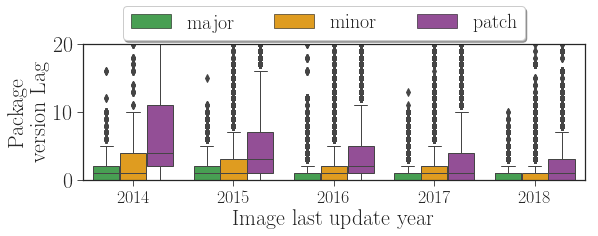

In [38]:
df_tmp=technical_lag.query('version_lag_today!="0,0,0"')

#### For those who are outdated! what is the technical lag
df_tmp['major']=df_tmp['version_lag_today'].apply(lambda x: int(x.split(',')[0]))
df_tmp['minor']=df_tmp['version_lag_today'].apply(lambda x: int(x.split(',')[1]))
df_tmp['patch']=df_tmp['version_lag_today'].apply(lambda x: int(x.split(',')[2]))
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0])

df_tmp.head(2)
#ax.figure.savefig('../../seneca_research/docker_debian/figures/version_lag.png', bbox_inches='tight', facecolor='white')

df_tmp2=df_tmp[['major','minor','patch','created']]
df_tmp2=pd.melt(df_tmp2, id_vars=['created'], value_vars=['major','minor','patch'])

ax = sns.boxplot(x="created", y="value", data=df_tmp2, hue='variable', palette=flatui, linewidth=1)

ax.figure.set_size_inches(9,2.5)
ax.set_xlabel("Image last update year")
ax.set_ylabel('Package \n version Lag')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(0.9, 1.35), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(0,20)
ax.figure.savefig('../../../seneca_research/docker_npm/figures/version_lag_today.pdf', bbox_inches='tight', facecolor='white')


In [33]:
for x in ['patch','minor','major']:
    print(x,df_tmp2.query('variable=="'+x+'"').query('created=="2018"').value.median())


patch 1.0
minor 0.0
major 1.0


# RQ2: How vulnerable are npm packages in containers?

In [88]:
vulnerabilities.head()

,package,version,versions,tag,base_os,created,id,name,published,severity,disclosed,affected
0,atob,2.0.3,<2.1.0,ghost:1.18-alpine,alpine,2017-12-09,npm:atob:20180429,Uninitialized Memory Exposure,"30 Apr, 2018",medium,"29 Apr, 2018",True
1,atob,2.0.3,<2.1.0,ghost:1.18.2,debian,2017-12-05,npm:atob:20180429,Uninitialized Memory Exposure,"30 Apr, 2018",medium,"29 Apr, 2018",True
2,atob,2.0.3,<2.1.0,ghost:1.18.2-alpine,alpine,2017-12-05,npm:atob:20180429,Uninitialized Memory Exposure,"30 Apr, 2018",medium,"29 Apr, 2018",True
3,atob,2.0.3,<2.1.0,ghost:1.18.3,debian,2017-12-07,npm:atob:20180429,Uninitialized Memory Exposure,"30 Apr, 2018",medium,"29 Apr, 2018",True
4,atob,2.0.3,<2.1.0,ghost:1.18.3-alpine,alpine,2017-12-07,npm:atob:20180429,Uninitialized Memory Exposure,"30 Apr, 2018",medium,"29 Apr, 2018",True


In [39]:
df_tmp=vulnerabilities.query('affected=="True"')[['id','disclosed','severity']].drop_duplicates()
df_tmp['disclosed']=df_tmp['disclosed'].apply(lambda x: x.split(',')[1])
df_tmp=df_tmp.groupby(['disclosed','severity']).count().reset_index()


Text(0.28,1.15,'Severity:')

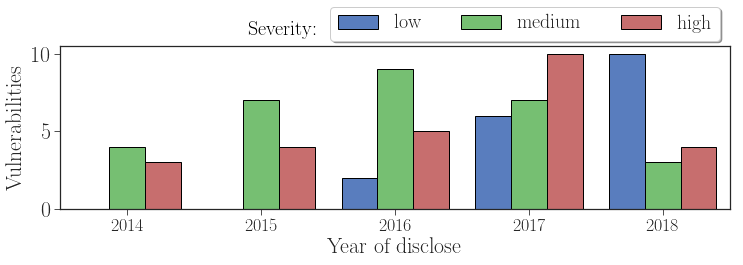

In [40]:
ax = sns.barplot(x="disclosed", 
                 y="id", 
                 hue="severity", 
                 data=df_tmp, 
                 hue_order=['low','medium','high'],
                 palette="muted", 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Year of disclose")
ax.set_ylabel('Vulnerabilities')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.28, 1.15, 'Severity:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')
#ax.figure.savefig('../../../papers/cloudtech18/figures/vuls.pdf', bbox_inches='tight', facecolor='white')


In [41]:
vulnerabilities.query('affected=="True"')[['id']].drop_duplicates().size

74

In [104]:
vulnerabilities.query('affected=="True"')[['package']].drop_duplicates().size

52

In [7]:
technical_lag.package.drop_duplicates().size

1412

In [36]:
df_tmp=vulnerabilities.query('affected=="True"')[['id','disclosed','severity']].drop_duplicates()
df_tmp['disclosed']=df_tmp['disclosed'].apply(lambda x: x.split(',')[1])
df_tmp.groupby('disclosed').count()/74

,id,severity
disclosed,,
2014,0.094595,0.094595
2015,0.148649,0.148649
2016,0.216216,0.216216
2017,0.310811,0.310811
2018,0.229730,0.229730


In [37]:
df_tmp=vulnerabilities.query('affected=="True"')[['id','disclosed','severity']].drop_duplicates()
df_tmp.groupby('severity').count()/74

,id,disclosed
severity,,
high,0.351351,0.351351
low,0.243243,0.243243
medium,0.405405,0.405405


In [38]:
df_tmp=vulnerabilities.query('affected=="True"')[['id','disclosed','severity']]
df_tmp['disclosed']=df_tmp['disclosed'].apply(lambda x: x.split(',')[1])
df_tmp=df_tmp.groupby(['disclosed','severity']).count().reset_index()


Text(0.28,1.15,'Severity:')

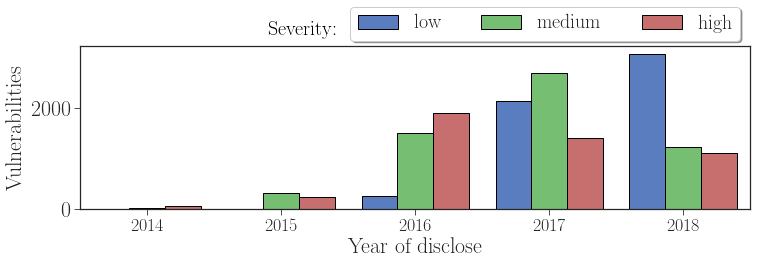

In [39]:
ax = sns.barplot(x="disclosed", 
                 y="id", 
                 hue="severity", 
                 data=df_tmp, 
                 hue_order=['low','medium','high'],
                 palette="muted", 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Year of disclose")
ax.set_ylabel('Vulnerabilities')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.28, 1.15, 'Severity:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')


In [40]:
df_tmp=vulnerabilities.query('affected=="True"')[['id','disclosed','severity']]
df_tmp['disclosed']=df_tmp['disclosed'].apply(lambda x: x.split(',')[1])
df_tmp.groupby('severity').count()/len(vulnerabilities.query('affected=="True"'))

,id,disclosed
severity,,
high,0.294955,0.294955
low,0.343341,0.343341
medium,0.361705,0.361705


(0, 30)

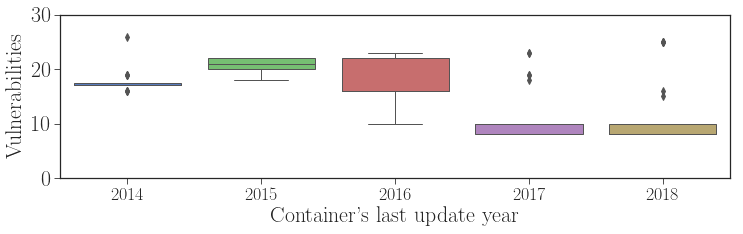

In [41]:
df_tmp=vulnerabilities.query('affected=="True"')[['created','base_os','severity','tag']]
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0])
df_tmp=df_tmp.groupby(['created','tag']).count().reset_index()

ax = sns.boxplot( x="created", y="severity", data=df_tmp, palette="muted", linewidth=1)

ax.figure.set_size_inches(12,3)
ax.set_xlabel("Container's last update year")
ax.set_ylabel('Vulnerabilities')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(0,30)

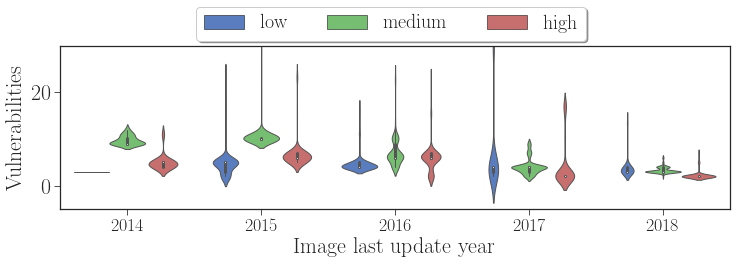

In [84]:
df_tmp=vulnerabilities.query('affected=="True"')[['created','base_os','severity','tag']]
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0])
df_tmp=df_tmp.groupby(['created','severity','tag']).count().reset_index()

ax = sns.violinplot(x="created", y="base_os", data=df_tmp, hue_order=['low','medium','high'],
                 hue='severity', palette="muted", linewidth=1)

ax.figure.set_size_inches(12,3)
ax.set_xlabel("Image last update year")
ax.set_ylabel('Vulnerabilities')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(-5,30)


In [43]:
df_tmp=vulnerabilities.query('affected=="True"').groupby(['tag']).count()
print(df_tmp.package.mean(),df_tmp.package.median())

16.602497398543186 10.0


In [44]:
df_tmp=vulnerabilities.query('affected=="True"').groupby(['tag','severity']).count()
for x in ['low','medium','high']:
    print(x, df_tmp.query('severity=="'+x+'"').package.mean()/16.6,df_tmp.query('severity=="'+x+'"').package.median()/11)

low 0.34339229968782514 0.36363636363636365
medium 0.3617592116645562 0.36363636363636365
high 0.29499893434299107 0.2727272727272727


In [45]:
df_tmp=vulnerabilities.query('affected=="True"')[['created','base_os','severity','tag']]
df_tmp=df_tmp.groupby(['created','severity','tag']).count().reset_index()
df_tmp['created']=df_tmp['created'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])
df_tmp['created']=pd.to_datetime(df_tmp['created'])
df_tmp['ts'] = df_tmp.created.values.astype(np.int64) // 10 ** 9



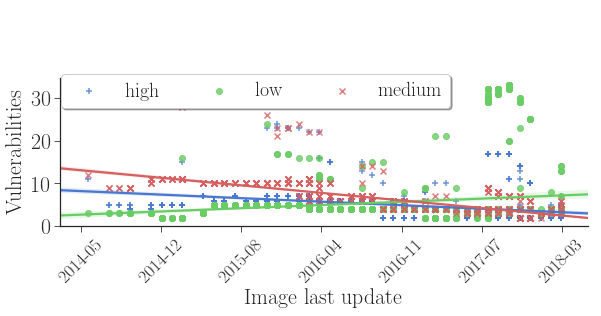

In [57]:
ax = sns.lmplot(x="ts", y='base_os', markers=["+", 'o','x'], hue="severity", palette='muted', data=df_tmp, legend='', size=8)
ax.set(xlabel="Image last update ", ylabel='Vulnerabilities')
ax.fig.set_size_inches(9,2.5)
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.71, 1.4), ncol=3, fontsize=20, fancybox=True, shadow=True)# ,ncol=3)

ax = plt.gca()
xticks = ax.get_xticks()
xticks_dates = [datetime.fromtimestamp(x).strftime('%Y-%m') for x in xticks]
ax.set_xticklabels(xticks_dates)
plt.xticks(rotation=45)
ax.figure.savefig('../../../seneca_research/docker_npm//figures/vuls_violin.pdf', bbox_inches='tight', facecolor='white')


In [48]:
for x in ['low','medium','high']:
    print(x, scipy.stats.pearsonr(df_tmp.query('severity=="'+x+'"')['base_os'],
                                  df_tmp.query('severity=="'+x+'"')['ts']))
print('all', scipy.stats.pearsonr(df_tmp['base_os'],
                              df_tmp['ts']))

low (0.16148917383109529, 4.8357782767682363e-07)
medium (-0.74831193940546248, 3.853699019840954e-173)
high (-0.28520049249117735, 1.9217135681021981e-19)
all (-0.17738403877171974, 8.2746919167522004e-22)


In [50]:
vulnerabilities['constraint']=vulnerabilities['versions'].apply(lambda x: x[0])

In [52]:
(vulnerabilities[['id','severity','constraint']]
 .drop_duplicates()
 .groupby(['severity','constraint']).
 count())


id
severity constraint    
high     *            2
         <           26
         >            2
low      *            1
         <           21
         >            1
medium   *            2
         <           58

In [56]:
scipy.stats.pearsonr(df_tmp['base_os'],df_tmp['ts'])

(-0.17738403877171974, 8.2746919167522004e-22)

In [57]:
scipy.stats.pearsonr(df_tmp.query('severity!="low"')['base_os'],df_tmp.query('severity!="low"')['ts'])

(-0.48542053162708909, 3.4929004379906876e-114)

In [103]:
len(vulnerabilities.query('affected=="True"').groupby(['tag']).count())

961

In [123]:
vulnerabilities.query('affected=="True"').package.drop_duplicates().size

52

In [117]:
a=vulnerabilities.query('affected=="True"')[['name','tag']].drop_duplicates()
a.groupby(['name']).count().sort_values('tag')

,tag
name,
Multiple Content Injection Vulnerabilities,1
VBScript Content Injection,1
Cross-site Scripting (XSS) via Data URIs,1
Content & Code Injection (XSS),1
Denial of Service (Memory Exhaustion),7
SQL Injection,7
Denial of Service (Event Loop Blocking),7
Improper minification of non-boolean comparisons,9
Open Redirect,10


In [122]:
a=vulnerabilities.query('affected=="True"')[['name','package']].drop_duplicates()
a.groupby(['name']).count().sort_values('package')/len(a.package.drop_duplicates())

,package
name,
Access Restriction Bypass,0.019231
Unauthorized SSL Connection due to lack of cert authentication,0.019231
Timing Attack,0.019231
Symlink File Overwrite,0.019231
SQL Injection,0.019231
Remote Memory Exposure,0.019231
Prototype Override Protection Bypass,0.019231
Open Redirect,0.019231
VBScript Content Injection,0.019231


In [126]:
a.query('name=="Prototype Override Protection Bypass"')

,name,package
25524,Prototype Override Protection Bypass,qs


In [105]:
vulnerabilities.query('affected=="True"').groupby(['name']).count().sort_values('package')

,package,version,versions,tag,base_os,created,id,published,severity,disclosed,affected
name,,,,,,,,,,,
Multiple Content Injection Vulnerabilities,1,1,1,1,1,1,1,1,1,1,1
VBScript Content Injection,1,1,1,1,1,1,1,1,1,1,1
Cross-site Scripting (XSS) via Data URIs,1,1,1,1,1,1,1,1,1,1,1
Content & Code Injection (XSS),1,1,1,1,1,1,1,1,1,1,1
Denial of Service (Memory Exhaustion),7,7,7,7,7,7,7,7,7,7,7
SQL Injection,7,7,7,7,7,7,7,7,7,7,7
Denial of Service (Event Loop Blocking),7,7,7,7,7,7,7,7,7,7,7
Improper minification of non-boolean comparisons,9,9,9,9,9,9,9,9,9,9,9
Open Redirect,10,10,10,10,10,10,10,10,10,10,10


In [195]:
(vulnerabilities.query('affected=="True"')[['id','name','severity']].
 drop_duplicates().groupby(['name','severity']).count().sort_values('id'))

,,id
name,severity,
Access Restriction Bypass,medium,1
Uninitialized Memory Exposure,low,1
Unauthorized SSL Connection due to lack of cert authentication,medium,1
Timing Attack,medium,1
Symlink File Overwrite,high,1
SQL Injection,medium,1
Remote Memory Exposure,medium,1
Regular Expression Denial of Service (DoS),low,1
VBScript Content Injection,medium,1


In [234]:
df_tmp0=technical_lag.query('version_lag_today!="0,0,0"')[['tag','package']]
#df_tmp0['created']=df_tmp0['created'].apply(lambda x: x.split('-')[0])
df_tmp0=df_tmp0.groupby(['tag',]).count().reset_index()

df_tmp1=vulnerabilities.query('affected=="True"')[['affected','tag','severity']]
df_tmp1=df_tmp1.groupby(['tag','severity']).count().reset_index()

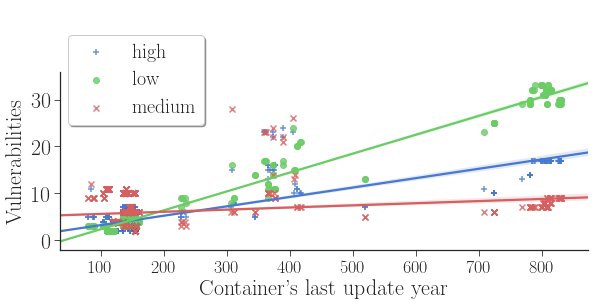

In [233]:
df_tmp=(df_tmp0.
        merge(df_tmp1,
              left_on="tag",
              right_on="tag",
              how='left')
       )

ax = sns.lmplot(x="package", y='affected', markers=["+", 'o','x'], hue="severity", palette='muted', data=df_tmp, legend='', size=8)
ax.set(xlabel="Container's last update year", ylabel='Vulnerabilities')
ax.fig.set_size_inches(9,3)
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.33, 1.3), fontsize=20, fancybox=True, shadow=True)# ,ncol=3)



In [236]:
df_tmp0=technical_lag.query('version_lag_today!="0,0,0"')[['tag','package','base_os']]
#df_tmp0['created']=df_tmp0['created'].apply(lambda x: x.split('-')[0])
df_tmp0=df_tmp0.groupby(['tag','base_os']).count().reset_index()

df_tmp1=vulnerabilities.query('affected=="True"')[['affected','tag']]
df_tmp1=df_tmp1.groupby(['tag']).count().reset_index()

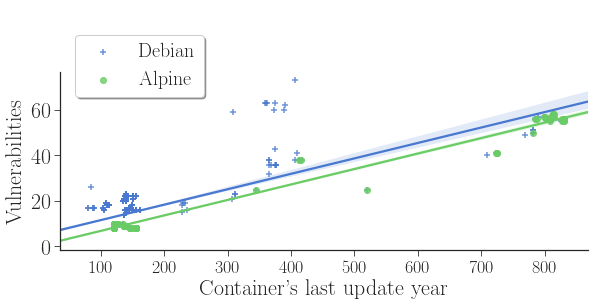

In [237]:
df_tmp=(df_tmp0.
        merge(df_tmp1,
              left_on="tag",
              right_on="tag",
              how='left')
       )

ax = sns.lmplot(x="package", y='affected', markers=["+", 'o',], hue="base_os", palette='muted', data=df_tmp, legend='', size=8)
ax.set(xlabel="Container's last update year", ylabel='Vulnerabilities')
ax.fig.set_size_inches(9,3)
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.33, 1.3), fontsize=20, fancybox=True, shadow=True)# ,ncol=3)

